In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
from typing import Union,List, Dict, Tuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import joblib
from credentials_geo import connection_params_geo
import numpy as np

with vistas as (
  SELECT event_date, event_timestamp, ep.value.string_value, REGEXP_EXTRACT(ep.value.string_value, r'/(\d+)$') AS spot_id
  FROM `analytics_276054961.events_*`,
  UNNEST(event_params) AS ep
  WHERE event_name = 'page_view'
    AND ep.key = 'page_location'
    AND ep.value.string_value LIKE '%https://spot2.mx/spots%'
    AND REGEXP_CONTAINS(ep.value.string_value, r'/\d+$')
 )
select event_date, vistas.spot_id, count(distinct(event_timestamp)) as conteo_vistas
from vistas 
group by 1, 2

In [2]:
vistas = pd.read_csv('views.csv')

In [3]:
def execute_query_postgres(query: str, connection_params: dict) -> Union[pd.DataFrame, None]:
    """
    Execute a SQL query on the PostgreSQL database and return the results as a pandas DataFrame.
    
    Args:
        query (str): SQL query to execute
        
    Returns:
        Union[pd.DataFrame, None]: DataFrame with query results or None if there was an error
    """
    try:
        # Connection parameters
        
        # Connect to the database
        connection = psycopg2.connect(**connection_params)
        
        # Create a cursor
        cursor = connection.cursor()
        
        # Execute the query
        cursor.execute(query)
        
        # If the query returns results, fetch them
        if cursor.description:
            # Get column names
            columns = [desc[0] for desc in cursor.description]
            
            # Fetch all rows
            rows = cursor.fetchall()
            
            # Create DataFrame
            df = pd.DataFrame(rows, columns=columns)
            
            return df
        else:
            # For queries that don't return results (INSERT, UPDATE, DELETE)
            connection.commit()
            return None
            
    except (Exception, Error) as error:
        print(f"Error while connecting to PostgreSQL: {error}")
        return None
        
    finally:
        # Close the cursor and connection
        if 'cursor' in locals():
            cursor.close()
        if 'connection' in locals():
            connection.close()

In [4]:
query_activos = """
    with spots as (
	select spot_id, spot_sector, spot_type, spot_modality, spot_latitude, spot_longitude, spot_area_in_sqm, spot_price_total_mxn_rent, spot_price_sqm_mxn_rent,spot_price_total_mxn_sale, spot_price_sqm_mxn_sale
	from lk_spots
	where spot_status_id = 1 
    and spot_type != 'Complex'
	AND spot_created_at::date BETWEEN (CURRENT_DATE - INTERVAL '60 days') AND (CURRENT_DATE - INTERVAL '30 days')
    )
    ,inquiries as (
        select count(*) as number_of_inquiries, i.spot_id
        from lk_inquiries i 
        join spots s on i.spot_id = s.spot_id
        group by 2 
    )
    select s.spot_id, spot_sector, spot_type, spot_modality, spot_latitude, spot_longitude, spot_area_in_sqm, spot_price_total_mxn_rent, spot_price_sqm_mxn_rent,spot_price_total_mxn_sale, spot_price_sqm_mxn_sale,
    i.number_of_inquiries
    from spots s 
    left join inquiries i on s.spot_id = i.spot_id
"""
query_totales = """
WITH spots AS (
    SELECT 
        spot_id,
        spot_sector,
        spot_type,
        spot_modality,
        spot_latitude,
        spot_longitude,
        spot_area_in_sqm,
        spot_price_total_mxn_rent,
        spot_price_sqm_mxn_rent,
        spot_price_total_mxn_sale,
        spot_price_sqm_mxn_sale,
        spot_created_at
    FROM lk_spots
    WHERE spot_created_at >= DATE '2024-11-01'
      AND spot_type != 'Complex'
),
inquiries AS (
    SELECT 
        i.spot_id,
        COUNT(*) AS number_of_inquiries
    FROM lk_inquiries i
    JOIN spots s ON i.spot_id = s.spot_id
    WHERE i.inquieries_day_created BETWEEN s.spot_created_at AND s.spot_created_at + INTERVAL '60 days'
    GROUP BY i.spot_id
)
SELECT 
    s.spot_id,
    s.spot_sector,
    s.spot_type,
    s.spot_modality,
    date(s.spot_created_at) as spot_created_at,
    s.spot_latitude,
    s.spot_longitude,
    s.spot_area_in_sqm,
    s.spot_price_total_mxn_rent,
    s.spot_price_sqm_mxn_rent,
    s.spot_price_total_mxn_sale,
    s.spot_price_sqm_mxn_sale,
    COALESCE(i.number_of_inquiries, 0) AS number_of_inquiries
FROM spots s
LEFT JOIN inquiries i ON s.spot_id = i.spot_id

"""
data = execute_query_postgres(query_totales, connection_params_geo)

In [5]:
data1 = data[['spot_id', 'spot_created_at']]

data1['spot_created_at'] = pd.to_datetime(data1['spot_created_at'])
vistas['event_date'] = pd.to_datetime(vistas['event_date'], format='%Y%m%d')


merged = vistas.merge(data1, on='spot_id', how='inner')


merged['dias_desde_creacion'] = (merged['event_date'] - merged['spot_created_at']).dt.days


filtered = merged[(merged['dias_desde_creacion'] >= 0) & (merged['dias_desde_creacion'] <= 60)]


conteo_final = filtered.groupby('spot_id')['conteo_vistas'].sum().reset_index()
conteo_final.rename(columns={'conteo_vistas': 'total_vistas_60_dias'}, inplace=True)


/var/folders/rc/wq7tqhnx6_75675dg0cml3n40000gn/T/ipykernel_71978/417494927.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['spot_created_at'] = pd.to_datetime(data1['spot_created_at'])


In [6]:
data = data.merge(conteo_final, on='spot_id', how='left')

In [7]:
data.groupby('spot_sector')['number_of_inquiries'].describe()

,count,mean,std,min,25%,50%,75%,max
spot_sector,,,,,,,,
Industrial,6724.0,0.095181,0.478464,0.0,0.0,0.0,0.0,11.0
Land,2446.0,0.121423,0.876631,0.0,0.0,0.0,0.0,28.0
Office,6225.0,0.082410,0.443593,0.0,0.0,0.0,0.0,11.0
Retail,5271.0,0.275849,1.146475,0.0,0.0,0.0,0.0,30.0


In [8]:
data.groupby('spot_sector')['total_vistas_60_dias'].describe()

,count,mean,std,min,25%,50%,75%,max
spot_sector,,,,,,,,
Industrial,939.0,3.755059,14.102188,1.0,1.0,2.0,4.0,412.0
Land,429.0,2.769231,3.491697,1.0,1.0,1.0,3.0,47.0
Office,951.0,3.732913,12.277414,1.0,1.0,1.0,3.0,238.0
Retail,1189.0,5.071489,18.395966,1.0,1.0,2.0,5.0,552.0


In [9]:
data.groupby('spot_modality')['number_of_inquiries'].describe()

,count,mean,std,min,25%,50%,75%,max
spot_modality,,,,,,,,
Rent,12781.0,0.192473,0.859018,0.0,0.0,0.0,0.0,30.0
Rent & Sale,717.0,0.145049,0.708010,0.0,0.0,0.0,0.0,11.0
Sale,7083.0,0.048002,0.506339,0.0,0.0,0.0,0.0,28.0


In [10]:
data.groupby('spot_modality')['total_vistas_60_dias'].describe()

,count,mean,std,min,25%,50%,75%,max
spot_modality,,,,,,,,
Rent,2675.0,4.383925,16.427474,1.0,1.0,2.0,4.00,552.0
Rent & Sale,124.0,4.233871,5.787720,1.0,1.0,2.0,4.25,36.0
Sale,709.0,2.880113,4.135558,1.0,1.0,1.0,3.00,47.0


<Axes: xlabel='spot_sector', ylabel='number_of_inquiries'>

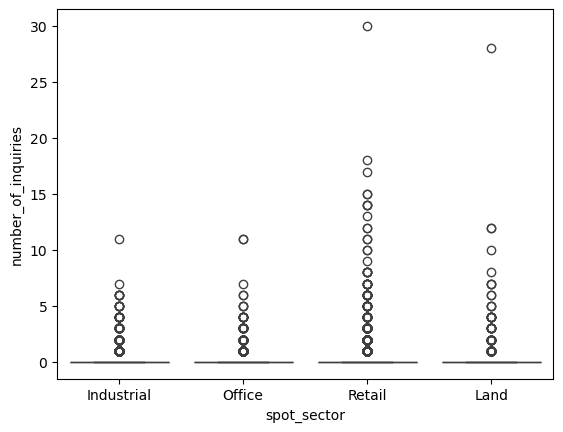

In [11]:
sns.boxplot(x='spot_sector', y='number_of_inquiries', data=data)

<Axes: xlabel='spot_sector', ylabel='total_vistas_60_dias'>

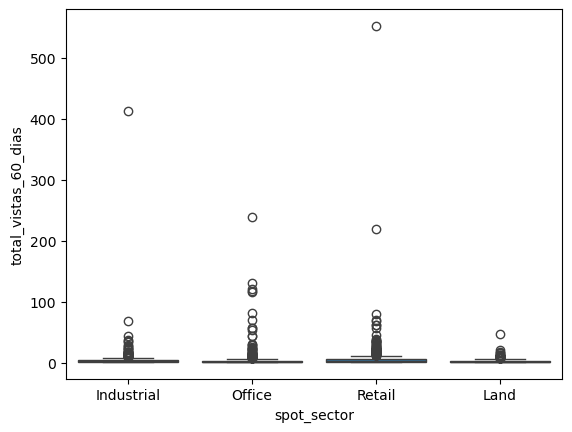

In [12]:
sns.boxplot(x='spot_sector', y='total_vistas_60_dias', data=data)

<Axes: xlabel='spot_modality', ylabel='number_of_inquiries'>

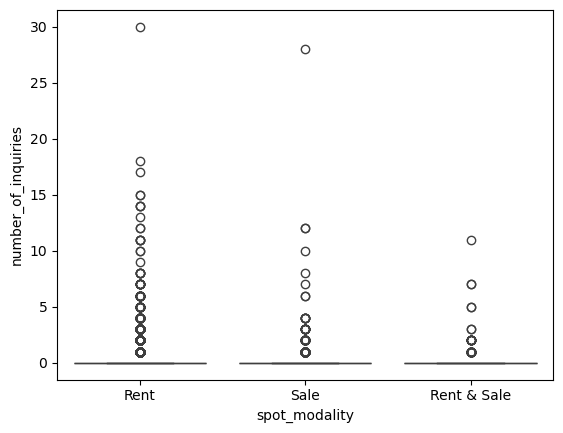

In [13]:
sns.boxplot(x='spot_modality', y='number_of_inquiries', data=data)

<Axes: xlabel='spot_modality', ylabel='total_vistas_60_dias'>

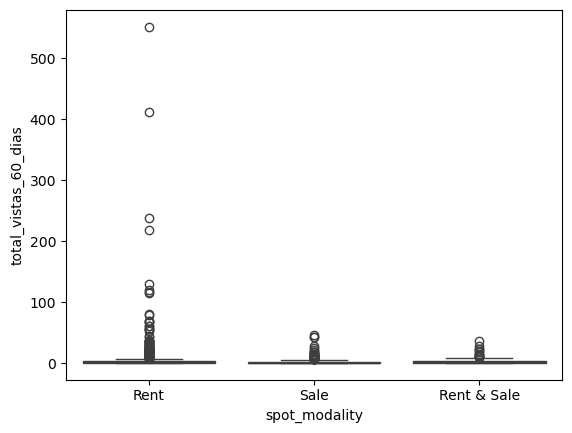

In [14]:
sns.boxplot(x='spot_modality', y='total_vistas_60_dias', data=data)

<Axes: xlabel='spot_sector', ylabel='spot_area_in_sqm'>

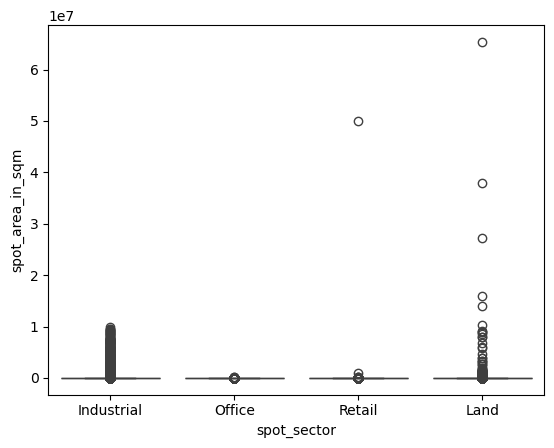

In [15]:
sns.boxplot(x='spot_sector', y='spot_area_in_sqm', data=data)

<Axes: xlabel='spot_sector', ylabel='spot_price_sqm_mxn_rent'>

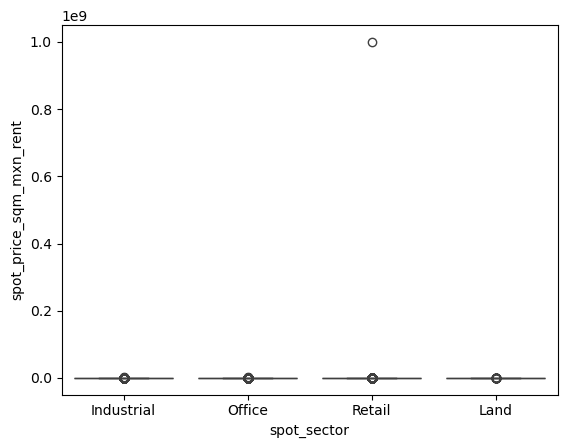

In [16]:
sns.boxplot(x='spot_sector', y='spot_price_sqm_mxn_rent', data=data)

<Axes: xlabel='spot_sector', ylabel='spot_price_total_mxn_rent'>

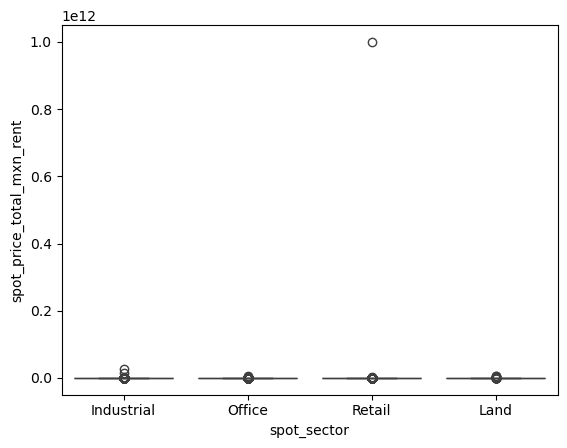

In [17]:
sns.boxplot(x='spot_sector', y='spot_price_total_mxn_rent', data=data)

<Axes: xlabel='spot_sector', ylabel='spot_price_sqm_mxn_sale'>

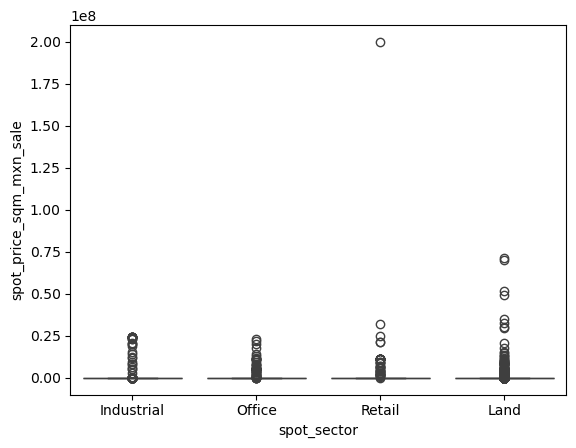

In [18]:
sns.boxplot(x='spot_sector', y='spot_price_sqm_mxn_sale', data=data)

<Axes: xlabel='spot_sector', ylabel='spot_price_total_mxn_sale'>

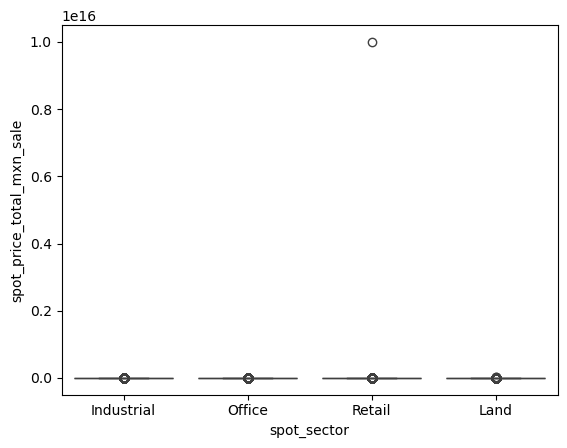

In [19]:
sns.boxplot(x='spot_sector', y='spot_price_total_mxn_sale', data=data)

<Axes: xlabel='spot_sector', ylabel='spot_latitude'>

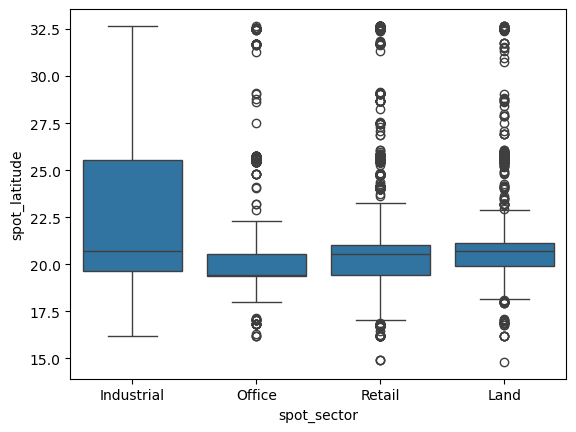

In [20]:
sns.boxplot(x='spot_sector', y='spot_latitude', data=data)

In [21]:
data['number_of_inquiries'].value_counts()

number_of_inquiries
0     19194
1       871
2       306
3       136
4        60
6        29
5        28
7        13
8         6
11        5
12        4
14        3
10        3
15        2
28        1
17        1
9         1
13        1
18        1
30        1
Name: count, dtype: int64

In [22]:
def train_model_by_modality(df: pd.DataFrame, modality: str) -> Tuple[RandomForestClassifier, List[str]]:
    """
    Entrena un RandomForestClassifier para predecir si una publicación tendrá al menos 1 inquiry,
    diferenciando variables según la modalidad ('Rent' o 'Sale').
    """
    df = df.copy()

    common_features = ["spot_type", "spot_latitude", "spot_longitude", "spot_area_in_sqm"]

    if modality == "Rent":
        price_features = ["spot_price_total_mxn_rent", "spot_price_sqm_mxn_rent"]
    elif modality == "Sale":
        price_features = ["spot_price_total_mxn_sale", "spot_price_sqm_mxn_sale"]
    else:
        raise ValueError("Modality must be 'Rent' or 'Sale'")

    feature_columns = common_features + price_features

    df_model = df[feature_columns + ["has_info"]].copy()
    df_model = pd.get_dummies(df_model)

    X = df_model.drop(columns="has_info")
    y = df_model["has_info"]

    model = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, class_weight="balanced")
    model.fit(X, y)

    return model, X.columns.tolist()

In [23]:
def predict_score_classifier(input_df: pd.DataFrame, model: BaseEstimator, feature_columns: List[str]) -> pd.DataFrame:
    input_df = input_df.copy()
    df_encoded = pd.get_dummies(input_df)
    df_encoded = df_encoded.reindex(columns=feature_columns, fill_value=0)

    y_proba = model.predict_proba(df_encoded)[:, 1]
    score = (y_proba * 100).round(1)

    input_df["probability"] = y_proba
    input_df["quality_score"] = score

    return input_df.reset_index(drop=True)


In [24]:
def evaluate_classifier_threshold(df: pd.DataFrame, thresholds: List[float] = [0.5], target_variable: str = "number_of_inquiries") -> dict:
    y_true = df[target_variable].fillna(0).apply(lambda x: 1 if x >= 1 else 0)
    roc = roc_auc_score(y_true, df["probability"])

    best_result = {
        "threshold": 0.5,
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "roc_auc": round(roc, 3)
    }

    for t in thresholds:
        y_pred = df["probability"].apply(lambda p: 1 if p >= t else 0)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

        f1 = report["1"]["f1-score"]
        if f1 > best_result["f1-score"]:
            best_result.update({
                "threshold": round(t, 2),
                "precision": round(report["1"]["precision"], 3),
                "recall": round(report["1"]["recall"], 3),
                "f1-score": round(f1, 3)
            })

    return best_result

In [25]:
def train_and_evaluate_by_segment(df: pd.DataFrame, target_variable: str) -> Tuple[pd.DataFrame, dict]:
    results = []

    for sector in df["spot_sector"].dropna().unique():
        for modality in df["spot_modality"].dropna().unique():
            df_segment = df[(df["spot_sector"] == sector) & (df["spot_modality"] == modality)]

            if len(df_segment) < 50:
                print(f"Skipping sector={sector}, modality={modality} because of insufficient data")
                continue

            try:
                df_segment = df_segment.copy()
                df_segment["has_info"] = df_segment[target_variable].fillna(0).apply(lambda x: 1 if x >= 1 else 0)

                df_train, df_test = train_test_split(
                    df_segment,
                    test_size=0.2,
                    random_state=42,
                    stratify=df_segment["has_info"]
                )

                model, feature_cols = train_model_by_modality(df_train, modality)
                df_pred = predict_score_classifier(df_test, model, feature_cols)
                metrics = evaluate_classifier_threshold(df_pred, thresholds=np.linspace(0.1, 0.9, 9), target_variable=target_variable)

                results.append({
                    "sector": sector,
                    "modality": modality,
                    "n_train": len(df_train),
                    "n_test": len(df_test),
                    **metrics
                })


            except Exception as e:
                print(f"Error con sector={sector}, modality={modality}: {e}")

    results_df = pd.DataFrame(results).sort_values(by="roc_auc", ascending=False).reset_index(drop=True)
    return results_df


In [26]:
def build_threshold_map(df: pd.DataFrame, target_variable: str = "number_of_inquiries") -> dict:
    """
    Construye un diccionario con el mejor threshold para cada combinación (sector, modality).
    """
    results_df = train_and_evaluate_by_segment(df, target_variable)

    threshold_map = {
        (row["sector"], row["modality"]): row["threshold"]
        for _, row in results_df.iterrows()
    }

    return threshold_map, results_df

In [36]:
data.fillna(0, inplace=True)
print(data.shape)
data_clean = data[data["spot_area_in_sqm"].between(data["spot_area_in_sqm"].quantile(0.01),
                                       data["spot_area_in_sqm"].quantile(0.90))]
print(data_clean.shape)

data_clean  = data_clean[data_clean["spot_price_sqm_mxn_sale"].between(data_clean["spot_price_sqm_mxn_sale"].quantile(0.01),
                                       data_clean["spot_price_sqm_mxn_sale"].quantile(0.90))]

print(data_clean.shape)
data_clean = data_clean[data_clean["spot_price_sqm_mxn_rent"].between(data_clean["spot_price_sqm_mxn_rent"].quantile(0.01),
                                       data_clean["spot_price_sqm_mxn_rent"].quantile(0.90))]
print(data_clean.shape)

(20666, 14)
(18394, 14)
(16556, 14)
(14999, 14)


<Axes: xlabel='spot_sector', ylabel='spot_area_in_sqm'>

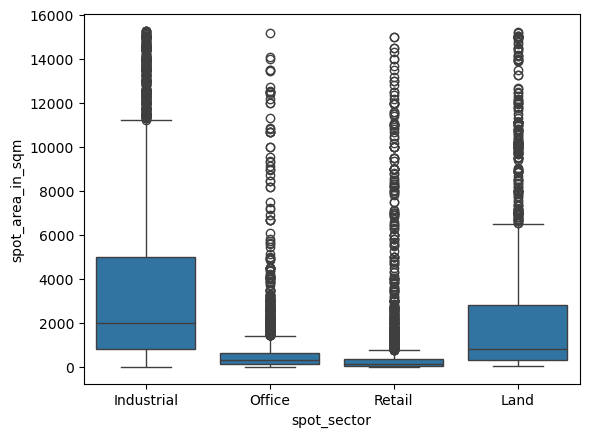

In [38]:
sns.boxplot(x='spot_sector', y='spot_area_in_sqm', data=data_clean)

<Axes: xlabel='spot_sector', ylabel='spot_price_sqm_mxn_sale'>

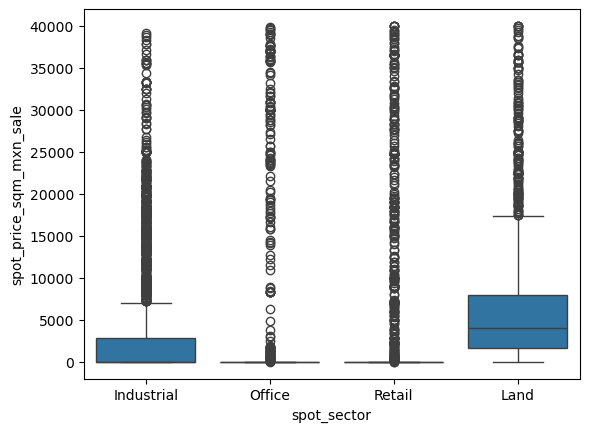

In [39]:
sns.boxplot(x='spot_sector', y='spot_price_sqm_mxn_sale', data=data_clean)

<Axes: xlabel='spot_sector', ylabel='spot_price_sqm_mxn_rent'>

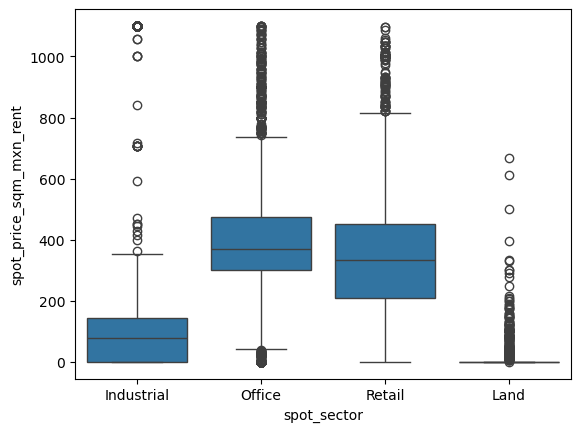

In [40]:
sns.boxplot(x='spot_sector', y='spot_price_sqm_mxn_rent', data=data_clean)

In [41]:
map_inquiries, results_inquiries  = build_threshold_map(data_clean, target_variable="number_of_inquiries")
map_vistas, results_vistas = build_threshold_map(data_clean, target_variable="total_vistas_60_dias")

Skipping sector=Industrial, modality=0 because of insufficient data
Error con sector=Industrial, modality=Rent & Sale: Modality must be 'Rent' or 'Sale'
Skipping sector=Office, modality=0 because of insufficient data
Skipping sector=Office, modality=Rent & Sale because of insufficient data
Skipping sector=Retail, modality=0 because of insufficient data
Skipping sector=Retail, modality=Rent & Sale because of insufficient data
Skipping sector=Land, modality=0 because of insufficient data
Skipping sector=Land, modality=Rent & Sale because of insufficient data
Skipping sector=Industrial, modality=0 because of insufficient data
Error con sector=Industrial, modality=Rent & Sale: Modality must be 'Rent' or 'Sale'
Skipping sector=Office, modality=0 because of insufficient data
Skipping sector=Office, modality=Rent & Sale because of insufficient data
Skipping sector=Retail, modality=0 because of insufficient data
Skipping sector=Retail, modality=Rent & Sale because of insufficient data
Skipping

In [44]:

log_threshold = 1.0  # ajusta según prefieras (1.0 ~ 2.7 vistas)

data_clean["has_views"] = data_clean["total_vistas_60_dias"].fillna(0).apply(lambda x: 1 if np.log1p(x) >= log_threshold else 0)
map_views_log, results_views_log = build_threshold_map(data_clean, target_variable="has_views")


Skipping sector=Industrial, modality=0 because of insufficient data
Error con sector=Industrial, modality=Rent & Sale: Modality must be 'Rent' or 'Sale'
Skipping sector=Office, modality=0 because of insufficient data
Skipping sector=Office, modality=Rent & Sale because of insufficient data
Skipping sector=Retail, modality=0 because of insufficient data
Skipping sector=Retail, modality=Rent & Sale because of insufficient data
Skipping sector=Land, modality=0 because of insufficient data
Skipping sector=Land, modality=Rent & Sale because of insufficient data


In [42]:
results_inquiries.head(10)

,sector,modality,n_train,n_test,threshold,precision,recall,f1-score,roc_auc
0,Industrial,Sale,1791,448,0.3,0.184,0.778,0.298,0.945
1,Land,Sale,1235,309,0.4,0.222,0.308,0.258,0.872
2,Industrial,Rent,2231,558,0.4,0.282,0.767,0.413,0.831
3,Retail,Sale,276,70,0.2,0.125,0.500,0.200,0.794
4,Land,Rent,130,33,0.1,0.250,0.750,0.375,0.789
5,Retail,Rent,2787,697,0.5,0.333,0.622,0.434,0.762
6,Office,Sale,117,30,0.5,0.000,0.000,0.000,0.759
7,Office,Rent,3199,800,0.4,0.153,0.471,0.231,0.702


In [43]:
results_vistas.head(10)

,sector,modality,n_train,n_test,threshold,precision,recall,f1-score,roc_auc
0,Industrial,Sale,1791,448,0.5,0.412,0.750,0.532,0.924
1,Retail,Sale,276,70,0.4,0.583,0.700,0.636,0.888
2,Land,Rent,130,33,0.3,0.684,0.929,0.788,0.835
3,Retail,Rent,2787,697,0.4,0.505,0.792,0.617,0.800
4,Land,Sale,1235,309,0.4,0.305,0.595,0.403,0.776
5,Industrial,Rent,2231,558,0.4,0.405,0.820,0.542,0.759
6,Office,Sale,117,30,0.5,0.600,0.500,0.545,0.757
7,Office,Rent,3199,800,0.4,0.286,0.635,0.395,0.696


In [45]:
results_views_log.head(10)

,sector,modality,n_train,n_test,threshold,precision,recall,f1-score,roc_auc
0,Industrial,Sale,1791,448,0.7,0.615,0.571,0.593,0.970
1,Retail,Rent,2787,697,0.5,0.414,0.748,0.533,0.840
2,Office,Sale,117,30,0.2,0.250,0.500,0.333,0.839
3,Land,Sale,1235,309,0.5,0.333,0.350,0.341,0.832
4,Industrial,Rent,2231,558,0.6,0.373,0.646,0.473,0.813
5,Retail,Sale,276,70,0.6,0.364,0.571,0.444,0.780
6,Land,Rent,130,33,0.2,0.421,1.000,0.593,0.755
7,Office,Rent,3199,800,0.5,0.236,0.439,0.307,0.728
